#### Exile on Online Opposition

Examine the effect of exile on percentage of tweets' harsh criticism of Venezuela government.

ESBERG, J., & SIEGEL, A. (2023). How Exile Shapes Online Opposition: Evidence from Venezuela. American Political Science Review, 117(4), 1361-1378.

In [1]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from matplotlib import pyplot as plt
from gpytorch.means import ZeroMean, LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

we first implement GPR for right panel of figure 4.

In [2]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_harsh_criticism", "lead_lags","month","num_tweets", "date_of_exile", "actor.id"]]
data = data[~data.lead_lags.isna()]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, dummies for lead_lags
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    pd.get_dummies(data['lead_lags']).values))).double()
ys = torch.tensor(data.perc_harsh_criticism.values).double()

we build a Gaussian process regression model with a linear mean function and an automatic relevance determination RBF kernel:
$$
f(t,D) \sim\mathcal{GP}(\beta x,K)
$$

In [3]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class ConstantVectorMean(Mean):
    def __init__(self, n, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, n)))
    
    def forward(self, input):
        return self.constantvector[input.long()]

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x = self.covar_module(x[:,2:]) + self.t_covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
from torch.utils.data import TensorDataset, DataLoader

inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.raw_outputscale.require_grad = False
model.t_covar_module.outputscale = 1.
model.covar_module.raw_outputscale.requires_grad = False
model.covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale,\
                model.covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.05)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 20
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Epoch 1 Iter 2 - Loss: 189.387
Epoch 1 Iter 3 - Loss: 171.395
Epoch 1 Iter 4 - Loss: 180.246
Epoch 1 Iter 5 - Loss: 153.973
Epoch 1 Iter 6 - Loss: 123.515
Epoch 1 Iter 7 - Loss: 135.347
Epoch 1 Iter 8 - Loss: 134.021
Epoch 1 Iter 9 - Loss: 108.920
Epoch 1 Iter 10 - Loss: 117.599
Epoch 1 Iter 11 - Loss: 99.884
Epoch 1 Iter 12 - Loss: 106.806
Epoch 1 Iter 13 - Loss: 98.195
Epoch 1 Iter 14 - Loss: 83.219
Epoch 1 Iter 15 - Loss: 88.809
Epoch 1 Iter 16 - Loss: 69.640
Epoch 1 Iter 17 - Loss: 86.759
Epoch 1 Iter 18 - Loss: 76.796
Epoch 1 Iter 19 - Loss: 74.686
Epoch 1 Iter 20 - Loss: 68.765
Epoch 1 Iter 21 - Loss: 79.623
Epoch 1 Iter 22 - Loss: 73.262
Epoch 1 Iter 23 - Loss: 93.771
Epoch 2 Iter 2 - Loss: 61.645
Epoch 2 Iter 3 - Loss: 67.123
Epoch 2 Iter 4 - Loss: 80.845
Epoch 2 Iter 5 - Loss: 62.349
Epoch 2 Iter 6 - Loss: 59.031
Epoch 2 Iter 7 - Loss: 69.160
Epoch 2 Iter 8 - Loss: 56.405
Epoch 2 Iter 9 - Loss: 58.166
Epoch 2 Iter 10 - Loss: 60.996
Epoch 2 Iter 11 - Loss: 59.692
Epoch 2 Iter 1

In [5]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [6]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [7]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).var(0) + \
                  sampled_dydtest_x.var(1).mean(0)).round(decimals=5)
covariate_names = ["time","log_num_tweets"]
for tmp in pd.get_dummies(data['lead_lags']).columns.tolist():
    covariate_names.append("beta "+tmp)
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:],
                        'est_std': est_std[1:]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                    x  est_mean  est_std          t        pvalue
0                time  0.020927  0.17694   0.118272  4.529259e-01
1      log_num_tweets  0.210572  1.12786   0.186700  4.259479e-01
2             beta -2  0.240525  0.10689   2.250208  1.221788e-02
3             beta -3  1.248433  0.16358   7.631941  1.154632e-14
4             beta -4 -0.005788  0.24611  -0.023519  4.906180e-01
5             beta -5  1.818973  0.48414   3.757121  8.593966e-05
6             beta -6  1.759444  0.48911   3.597235  1.608087e-04
7              beta 0  3.118248  0.30660  10.170410  0.000000e+00
8              beta 1  4.521140  0.08985  50.318752  0.000000e+00
9             beta 10  4.672294  0.10510  44.455696  0.000000e+00
10            beta 11  3.846667  0.27862  13.806140  0.000000e+00
11             beta 2  4.461598  0.56303   7.924263  1.110223e-15
12             beta 3  4.059089  0.08226  49.344629  0.000000e+00
13             beta 4  2.896020  0.10533  27.494733  0.000000e+00
14        

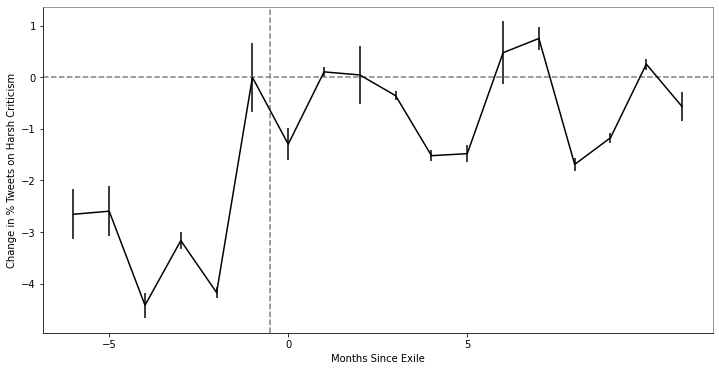

In [8]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_est_mean = []
plot_est_std = []
for i in range(-6,12):
    if i==-7:
        plot_est_mean.append(results[results.x==("beta pre")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta pre")].est_std.values[0])
    elif i==12:
        plot_est_mean.append(results[results.x==("beta post")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta post")].est_std.values[0])
    elif i==-1:
        plot_est_mean.append(results[results.x==("beta month_before")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta month_before")].est_std.values[0])
    else:
        plot_est_mean.append(results[results.x==("beta "+str(i))].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta "+str(i))].est_std.values[0])
ax.errorbar([i  for i in range(-6,12)], np.array(plot_est_mean)-plot_est_mean[5], yerr=plot_est_std, fmt="k", ecolor="k")
ax.axvline(x=-0.5, ls="--", color="gray")
ax.axhline(y=0, ls="--", color="gray")
ax.set_xlabel("Months Since Exile")
ax.set_ylabel("Change in % Tweets on Harsh Criticism")
ax.set_xticks(range(-5,10,5))
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')

next we estimate effect of exile on percentage of harsh criticism for left panel of figure 4.

In [9]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_harsh_criticism", "exile", "month","num_tweets", "date_of_exile", "actor.id"]]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, exile
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    data['exile'].values.reshape((-1,1))=="yes")))
ys = torch.tensor(data.perc_harsh_criticism.values).double()

In [10]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1,2]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x =  self.t_covar_module(x) # self.covar_module(x[:,2:]) +
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.05)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 10
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


Epoch 1 Iter 2 - Loss: 128.674
Epoch 1 Iter 3 - Loss: 142.321
Epoch 1 Iter 4 - Loss: 122.990
Epoch 1 Iter 5 - Loss: 122.264
Epoch 1 Iter 6 - Loss: 102.037
Epoch 1 Iter 7 - Loss: 104.153
Epoch 1 Iter 8 - Loss: 105.803
Epoch 1 Iter 9 - Loss: 95.417
Epoch 1 Iter 10 - Loss: 96.793
Epoch 1 Iter 11 - Loss: 115.301
Epoch 1 Iter 12 - Loss: 101.187
Epoch 1 Iter 13 - Loss: 98.655
Epoch 1 Iter 14 - Loss: 84.077
Epoch 1 Iter 15 - Loss: 88.689
Epoch 1 Iter 16 - Loss: 93.271
Epoch 1 Iter 17 - Loss: 91.184
Epoch 1 Iter 18 - Loss: 70.934
Epoch 1 Iter 19 - Loss: 76.790
Epoch 1 Iter 20 - Loss: 74.969
Epoch 1 Iter 21 - Loss: 57.952
Epoch 1 Iter 22 - Loss: 67.034
Epoch 1 Iter 23 - Loss: 54.628
Epoch 2 Iter 2 - Loss: 68.388
Epoch 2 Iter 3 - Loss: 67.901
Epoch 2 Iter 4 - Loss: 71.080
Epoch 2 Iter 5 - Loss: 63.189
Epoch 2 Iter 6 - Loss: 48.191
Epoch 2 Iter 7 - Loss: 68.768
Epoch 2 Iter 8 - Loss: 59.414
Epoch 2 Iter 9 - Loss: 58.377
Epoch 2 Iter 10 - Loss: 59.881
Epoch 2 Iter 11 - Loss: 55.759
Epoch 2 Iter 12

In [12]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [13]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [14]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).var(0) + \
                  sampled_dydtest_x.var(1).mean(0)).round(decimals=5)
covariate_names = ["time","log_num_tweets"]
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:3],
                        'est_std': est_std[1:3]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                x  est_mean  est_std          t    pvalue
0            time  0.028699  0.28019   0.102429  0.459208
1  log_num_tweets  2.741153  0.04412  62.129491  0.000000


In [15]:
model.eval()
likelihood.eval()

# copy training tesnor to test tensors and set exile to 1 and 0
test_x1 = xs.clone().detach().requires_grad_(False)
test_x1[:,3] = 1
test_x0 = xs.clone().detach().requires_grad_(False)
test_x0[:,3] = 0

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out1 = likelihood(model(test_x1))
    out0 = likelihood(model(test_x0))

# compute ATE and its uncertainty
effect = out1.mean.numpy().mean() - out0.mean.numpy().mean()
effect_std = np.sqrt((out1.mean.numpy().mean()+out0.mean.numpy().mean())) / np.sqrt(xs.size()[0])
BIC = (1+1+2+1)*\
    torch.log(torch.tensor(xs.size()[0])) + 2*loss*xs.size(0)/1024
print("ATE: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*xs.size(0)/1024))
print("BIC: {:0.3f} \n".format(BIC))

ATE: 3.859 +- 0.034

model evidence: -558.254 

BIC: 1166.651 

